# Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Scikit-learn utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline as make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    recall_score, precision_score, f1_score,
    make_scorer, fbeta_score, cohen_kappa_score
)


# Imbalance handling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek, SMOTEENN

# XGBoost
from xgboost import XGBClassifier

# Category encoders
import category_encoders as ce

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/housing-classification-iter6.csv')

In [3]:
houses.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,KitchenQual,FireplaceQu,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,MiscVal,MoSold,YrSold,Id,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,BsmtFinType2,HeatingQC,Electrical,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc,Gd,TA,Gd,TA,No,GLQ,Gd,NaN,60,7,5,2003,2003,196.0,706,0,150,856,854,0,1710,1,0,2,1,1,8,2003.0,548,61,0,0,0,2,2008,1,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock,TA,TA,Gd,TA,Gd,ALQ,TA,TA,20,6,8,1976,1976,0.0,978,0,284,1262,0,0,1262,0,1,2,0,1,6,1976.0,460,0,0,0,0,5,2007,2,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc,Gd,TA,Gd,TA,Mn,GLQ,Gd,TA,60,7,5,2001,2002,162.0,486,0,434,920,866,0,1786,1,0,2,1,1,6,2001.0,608,42,0,0,0,9,2008,3,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,9550,60.0,756,3,1,0,3,0,0,0,RL,Norm,GasA,Pave,Y,BrkTil,TA,TA,TA,Gd,No,ALQ,Gd,Gd,70,7,5,1915,1970,0.0,216,0,540,961,756,0,1717,1,0,1,0,1,7,1998.0,642,35,272,0,0,2,2006,4,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,Unf,Gd,SBrkr,Typ,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,14260,84.0,1145,4,1,0,3,192,0,0,RL,Norm,GasA,Pave,Y,PConc,Gd,TA,Gd,TA,Av,GLQ,Gd,TA,60,8,5,2000,2000,350.0,655,0,490,1145,1053,0,2198,1,0,2,1,1,9,2000.0,836,84,0,0,0,12,2008,5,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [4]:
# Drop Id
houses.drop(columns='Id', inplace = True)

# Splitting Data

In [5]:
X = houses.drop(columns='Expensive')
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
y_train.value_counts()

0    999
1    169
Name: Expensive, dtype: int64

# Preparing Pipeline

In [7]:
categoric_features = list(X_train.select_dtypes(include=["object"]))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))

Some of the categorical features can be transformed with the ordinal encoder. So let us make a distinction about which columns that are.

In [8]:
cat_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
cat_onehot = [feature for feature in categoric_features if feature not in cat_ordinal]

In [9]:
# Define the custom orders
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_ExterQual, order_ExterCond,
        order_BsmtQual, order_BsmtCond, order_BsmtExposure, order_BsmtFinType1,
        order_BsmtFinType2, order_HeatingQC, order_KitchenQual, order_FireplaceQu,
        order_GarageQual, order_GarageCond, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [10]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy='mean')
)

categoric_pipe_onehot = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
)

categoric_pipe_ordinal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc 
)

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe_onehot", categoric_pipe_onehot, cat_onehot),
        ("cat_pipe_ordinal", categoric_pipe_ordinal, cat_ordinal),
    ]
)

# Feature Importance

In [12]:
# Feature selector using XGBClassifier
selector = SelectFromModel(XGBClassifier(random_state=42), threshold='mean')  # Here, we're selecting features whose importance is greater than the mean importance.

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('resampler', ADASYN(random_state=42)),
    ('feature_selection', selector),
    ('model', XGBClassifier(random_state=42))
])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF', 'ScreenPorch',
                                                   'MSSubClass', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

## See Features

In [14]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
print(X_train_transformed.shape)

(1168, 207)


In [15]:
def get_feature_names_after_column_transformer(column_transformer, input_features):
    # Convert input_features to a list for indexing
    input_features = list(input_features)
    
    # List to hold the output feature names
    output_features = []

    # Loop through the transformers of the ColumnTransformer
    for transformer_name, transformer, columns in column_transformer.transformers_:
        # If columns is integer indices, extract the corresponding column names
        if all(isinstance(col, int) for col in columns):
            cols_names = [input_features[idx] for idx in columns]
        else:
            cols_names = columns
            
        # For transformers that have a `get_feature_names_out` method (new in sklearn 0.24)
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_features = transformer.get_feature_names_out(cols_names)
        # For transformers without `get_feature_names_out`
        else:
            transformed_features = np.array(input_features)[columns]

        output_features.extend(transformed_features)

    return output_features

# Get the feature names after preprocessing
features_after_preprocessing = get_feature_names_after_column_transformer(pipeline.named_steps['preprocessor'], X_train.columns)

# Get the boolean mask from the feature selector
mask = pipeline.named_steps['feature_selection'].get_support()

# Apply the mask to the features after preprocessing
selected_features = np.array(features_after_preprocessing)[mask]
selected_features

array(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr',
       'Fireplaces', 'GarageCars', 'OverallQual', 'YearRemodAdd',
       'BsmtFinSF1', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'MoSold',
       'MSZoning_FV', 'Condition1_Norm', 'Foundation_CBlock',
       'LotShape_IR2', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_Inside', 'LandSlope_Mod', 'Neighborhood_ClearCr',
       'Neighborhood_Edwards', 'RoofMatl_CompShg', 'RoofMatl_Tar&Grv',
       'Exterior1st_BrkFace', 'Exterior2nd_Plywood', 'GarageType_Attchd',
       'SaleType_New', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'KitchenQual'], dtype='<U21')

## Evaluate Model

In [16]:
y_train_pred = pipeline.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [17]:
y_test_pred = pipeline.predict(X_test)

accuracy_score(y_test, y_test_pred)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [17, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9623287671232876

In [18]:
recall_score(y_test, y_test_pred)

0.875

### Confusion Matrix

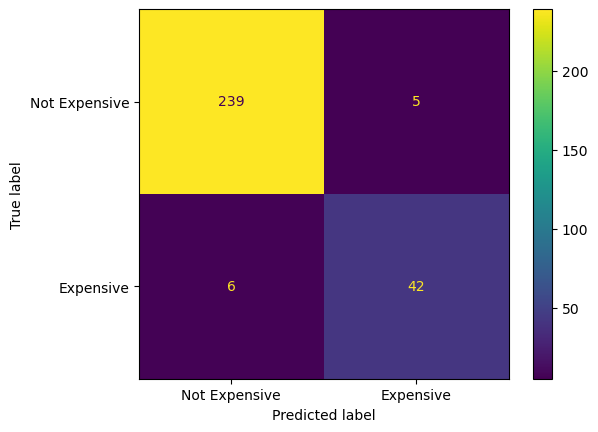

In [20]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Expensive', 'Expensive'])
disp.plot()

plt.show()

In [21]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

0.861718615464095


In [22]:
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8842


In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

Specificity: 0.9795


In [24]:
precision = precision_score(y_test, y_test_pred)
precision

0.8936170212765957

In [25]:
recall_score(y_test, y_test_pred)

0.875

# Oversampling

In [ ]:
resampling = [
    (RandomOverSampler(random_state=42), False), # No scaling needed
    (SMOTE(random_state=42), True), # Scaling needed
    (ADASYN(random_state=42), True), # Scaling needed
    (RandomUnderSampler(random_state=42), False), # No scaling needed
    (TomekLinks(), False), # No scaling needed
    (NeighbourhoodCleaningRule(), False), # No scaling needed
    (SMOTETomek(random_state=42), True), # Scaling needed
    (SMOTEENN(random_state=42), True)  # Scaling needed
]

In [ ]:
results = pd.DataFrame(columns=['algorithm', 'accuracy', 'recall_score', 'precision'])

for re, needs_scaling in resampling:
    
    steps = [('preprocessor', preprocessor)]
    
    if needs_scaling:
        steps.append(('scaler', StandardScaler()))
        
    steps.extend([
        ('resampler', re),
        ('feature_selection', selector),
        ('model', xgb_clf)
    ])
    
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    print(f'{re} - accuracy score train: {accuracy_score(y_train, y_train_pred)}')
    
    y_test_pred = pipeline.predict(X_test)
    print(f'{re} - accuracy score test: {accuracy_score(y_test, y_test_pred)}')
    
    accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Assuming a binary classification. Modify if multi-class.
    precision = precision_score(y_test, y_test_pred)  # Assuming a binary classification. Modify if multi-class.
    
    temp_df = pd.DataFrame({
        'algorithm': [re.__class__.__name__],
        'accuracy': [accuracy],
        'recall_score': [recall],
        'precision': [precision]
    })
    
    results = pd.concat([results, temp_df], ignore_index=True)
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Expensive', 'Expensive'])
    disp.plot()
    plt.show()
    
    

In [ ]:
results

# Grid Search

## Preparing Pipeline

Here we prepare part of the pipeline again, since we delete preset things such as strategy or threshold to tune them in the gridsearch. The rest stays the same.

In [26]:
numeric_pipe = make_pipeline(
    SimpleImputer()
)

categoric_pipe_onehot = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
)

categoric_pipe_ordinal = make_pipeline(
    SimpleImputer(),
    ordinal_enc 
)

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe_onehot", categoric_pipe_onehot, cat_onehot),
        ("cat_pipe_ordinal", categoric_pipe_ordinal, cat_ordinal),
    ]
)

In [28]:
# Feature selector using XGBClassifier
selector = SelectFromModel(XGBClassifier(random_state=42))  # Here, we're selecting features whose importance is greater than the mean importance.

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('resampler', ADASYN(random_state=42)),
    ('feature_selection', selector),
    ('model', XGBClassifier(random_state=42))
])

## Randomized Grid Search

In [29]:
param_grid = {
    "preprocessor__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "preprocessor__cat_pipe_ordinal__simpleimputer__strategy": ["most_frequent", 'constant'],
    "preprocessor__cat_pipe_onehot__simpleimputer__strategy": ["constant", "most_frequent"],
    
    "feature_selection__threshold": ['median', 'mean', '0.*', *np.arange(0.0, 0.05, 0.01)],
    
    'model__booster': ['gbtree', 'dart'],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.5, 1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__colsample_bylevel': [0.6, 0.8, 1.0],
    'model__reg_lambda': [0.1, 1, 5],
    'model__reg_alpha': [0, 0.1, 1],
    'model__tree_method': ['auto', 'exact', 'hist'],
    'model__grow_policy': ['depthwise', 'lossguide']  # if you're using 'hist' or 'approx' tree_method
    
}

In [30]:
search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=1000,
    cv=10,
    verbose=1,
    n_jobs=-2
)

In [31]:
search.fit(X_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [17, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 13, 17, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/mer

KeyboardInterrupt: 

### Classification performance metrics

In [ ]:
search.best_score_

In [ ]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

In [ ]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

In [ ]:
search.best_params_

In [ ]:
recall_score(y_test, y_test_pred)

#### Confusion Matrix

In [ ]:
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Expensive', 'Expensive'])
disp.plot()

plt.show()

In [ ]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

In [ ]:
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

In [ ]:
precision = precision_score(y_test, y_test_pred)
precision

In [ ]:
recall_score(y_test, y_test_pred)

## Grid Search

In [ ]:
param_grid = {
    "preprocessor__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "preprocessor__cat_pipe_ordinal__simpleimputer__strategy": ["most_frequent", 'constant'],
    "preprocessor__cat_pipe_onehot__simpleimputer__strategy": ["constant", "most_frequent"],
    
    "feature_selection__threshold": ['median', 'mean', '0.*', *np.arange(0.0, 0.05, 0.01)],
    
    'model__booster': ['gbtree', 'dart'],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.5, 1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__colsample_bylevel': [0.6, 0.8, 1.0],
    'model__reg_lambda': [0.1, 1, 5],
    'model__reg_alpha': [0, 0.1, 1],
    'model__tree_method': ['auto', 'exact', 'hist'],
    'model__grow_policy': ['depthwise', 'lossguide']  # if you're using 'hist' or 'approx' tree_method
    
}

In [ ]:
recall = make_scorer(recall_score)

In [ ]:
search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    verbose=1,
    n_jobs=-2
)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
search.best_score_

In [ ]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

In [ ]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

In [ ]:
search.best_params_

In [ ]:
recall_score(y_test, y_test_pred)

### Classification performance metrics

#### Confusion Matrix

In [ ]:
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Expensive', 'Expensive'])
disp.plot()

plt.show()

In [ ]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

In [ ]:
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

In [ ]:
precision = precision_score(y_test, y_test_pred)
precision

In [ ]:
recall_score(y_test, y_test_pred)

# Uploading the final result

In [ ]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/test.csv')

In [ ]:
new_data.columns

In [ ]:
X_train.columns

In [ ]:
id_col = new_data.pop('Id')

new_data.columns

In [32]:
search.best_estimator_.fit(X,y)

AttributeError: 'RandomizedSearchCV' object has no attribute '_best_estimators'

In [ ]:
expensive = search.best_estimator_.predict(new_data)
expensive

In [ ]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'Expensive':expensive
})

In [ ]:
submission_file.head()

In [ ]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/submission_merle_6.csv',index=False)